In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from joblib import dump

In [4]:
wolf_rayet = pd.read_csv('Archivos/Muestra4/wolfr_rgl.csv')
muestra_aleatoria = pd.read_csv('Archivos/Muestra/muestra_entrenamiento_final.csv')

In [5]:
muestra_aleatoria.shape

(4813, 256)

In [6]:
pd.set_option('display.max_rows', None)
main_type_counts = muestra_aleatoria['main_type'].value_counts()

print("Número de valores únicos para 'main_type':")
print(main_type_counts)

Número de valores únicos para 'main_type':
main_type
EclBin          1504
YSO             1197
EmLine*          683
Be*              508
TTauri*          405
LongPeriodV*     281
Eruptive*         70
BlueSG            67
C*                58
HighMassXBin      23
RGB*              16
AGB*               1
Name: count, dtype: int64


In [7]:
def verificar_nan(df, nombre_df, filtro_menor_a=None):
    nan_por_columna = df.isna().sum()
    
    if filtro_menor_a is not None:
        nan_por_columna = nan_por_columna[nan_por_columna < filtro_menor_a]
        print(f'Cantidad de NaN por columna en {nombre_df} (menos de {filtro_menor_a} NaNs):\n')
    else:
        print(f'Cantidad de NaN por columna en {nombre_df} (todas las columnas):\n')
    
    print(nan_por_columna)
    print('\n')

verificar_nan(wolf_rayet, 'wolf_rayet', filtro_menor_a=100)

verificar_nan(muestra_aleatoria, 'muestra_aleatoria')

Cantidad de NaN por columna en wolf_rayet (menos de 100 NaNs):

Unnamed: 0.3                        0
Unnamed: 0.2                        0
Unnamed: 0                          0
ID                                  0
WR#                                 0
Reference                           0
Alias2                             24
Right Ascension J2000               0
Declination J2000                   0
Galactic Longitude (deg)            0
Galactic Latitude (deg)             0
Spectral Type                       0
Spectral Type Reference             0
b (WR)                             95
v (WR)                             93
G                                   0
J                                   9
H                                   9
K                                  10
Distance (kpc)                      1
Distance Reference                  1
RA_deg                              0
Dec_deg                             0
WR_Combined                        79
WR Identifier           

In [8]:
print("Wolf rayet:", wolf_rayet.shape)
print(list(wolf_rayet.columns))
print("Muestra aleatoria:", muestra_aleatoria.shape)
print(list(muestra_aleatoria.columns))

Wolf rayet: (240, 325)
['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0', 'ID', 'WR#', 'Reference', 'HD', 'Alias1', 'Alias2', 'Alias3', 'Right Ascension J2000', 'Declination J2000', 'Galactic Longitude (deg)', 'Galactic Latitude (deg)', 'Spectral Type', 'Spectral Type Reference', 'Binary Status', 'Binary Status Reference', 'u (WR)', 'b (WR)', 'v (WR)', 'r (WR)', 'U', 'B', 'V', 'G', 'J', 'H', 'K', 'Cluster', 'Association', 'Star Forming Region', 'Distance (kpc)', 'Distance Reference', 'RA_deg', 'Dec_deg', 'WR_Combined', 'WR Identifier', 'Gaia DR3 ID', 'Gaia DR2 ID', 'Gaia DR1 ID', '2MASS ID', 'WISE ID', 'Gaia ID Query', 'SOURCE_ID', 'solution_id', 'DESIGNATION', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pm', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'pa

In [9]:
wolf_rayet['class'] = 1
muestra_aleatoria['class'] = 0

In [10]:
valores_wolf_rayet = wolf_rayet['phot_variable_flag'].unique()
valores_muestra_aleatoria = muestra_aleatoria['phot_variable_flag'].unique()
print("Valores únicos en 'phot_variable_flag' de wolf_rayet:", valores_wolf_rayet)
print("Valores únicos en 'phot_variable_flag' de muestra_aleatoria:", valores_muestra_aleatoria)

mapeo_variable_flag = {valor: indice for indice, valor in enumerate(set(valores_wolf_rayet) | set(valores_muestra_aleatoria))}
print("\nMapeo de valores a números:", mapeo_variable_flag)
wolf_rayet['phot_variable_flag'] = wolf_rayet['phot_variable_flag'].map(mapeo_variable_flag)
muestra_aleatoria['phot_variable_flag'] = muestra_aleatoria['phot_variable_flag'].map(mapeo_variable_flag)
print("\nLos valores de la columna 'phot_variable_flag' han sido convertidos a números.")

Valores únicos en 'phot_variable_flag' de wolf_rayet: ['VARIABLE' 'NOT_AVAILABLE']
Valores únicos en 'phot_variable_flag' de muestra_aleatoria: ['VARIABLE' 'NOT_AVAILABLE']

Mapeo de valores a números: {'VARIABLE': 0, 'NOT_AVAILABLE': 1}

Los valores de la columna 'phot_variable_flag' han sido convertidos a números.


In [11]:
wolf_rayet_sample = wolf_rayet.sample(n=15, random_state=42) 
wolf_rayet_restante = wolf_rayet.drop(wolf_rayet_sample.index)

wolf_rayet_sample.reset_index(drop=True, inplace=True)
wolf_rayet = wolf_rayet_restante.reset_index(drop=True)

In [12]:
wolf_rayet.shape

(225, 326)

In [13]:
combined_df = pd.concat([wolf_rayet, muestra_aleatoria], ignore_index=True)
print(combined_df.shape)
print(list(combined_df.columns))

(5038, 372)
['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0', 'ID', 'WR#', 'Reference', 'HD', 'Alias1', 'Alias2', 'Alias3', 'Right Ascension J2000', 'Declination J2000', 'Galactic Longitude (deg)', 'Galactic Latitude (deg)', 'Spectral Type', 'Spectral Type Reference', 'Binary Status', 'Binary Status Reference', 'u (WR)', 'b (WR)', 'v (WR)', 'r (WR)', 'U', 'B', 'V', 'G', 'J', 'H', 'K', 'Cluster', 'Association', 'Star Forming Region', 'Distance (kpc)', 'Distance Reference', 'RA_deg', 'Dec_deg', 'WR_Combined', 'WR Identifier', 'Gaia DR3 ID', 'Gaia DR2 ID', 'Gaia DR1 ID', '2MASS ID', 'WISE ID', 'Gaia ID Query', 'SOURCE_ID', 'solution_id', 'DESIGNATION', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pm', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmde

In [14]:
combined_df.to_csv('Archivos/Muestra//muestra_combinada.csv')

# Oversampling
### Utilizaré modelos de SMOTE-ENN y SMOTE-TOMEK porque leí que limpian parámetros de la frontera en las clases mayoritarias, lo cual creo que puede ser útil debido a que en muchos gráficos color-color las fronteras no están realmente tan claras. 

In [16]:
df = pd.read_csv('Archivos/Muestra//muestra_combinada.csv')
wolf_rayet = pd.read_csv('Archivos/Crowther/catalogo_entrenamiento_filtradototal.csv')
print(list(df.columns))

['Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0', 'ID', 'WR#', 'Reference', 'HD', 'Alias1', 'Alias2', 'Alias3', 'Right Ascension J2000', 'Declination J2000', 'Galactic Longitude (deg)', 'Galactic Latitude (deg)', 'Spectral Type', 'Spectral Type Reference', 'Binary Status', 'Binary Status Reference', 'u (WR)', 'b (WR)', 'v (WR)', 'r (WR)', 'U', 'B', 'V', 'G', 'J', 'H', 'K', 'Cluster', 'Association', 'Star Forming Region', 'Distance (kpc)', 'Distance Reference', 'RA_deg', 'Dec_deg', 'WR_Combined', 'WR Identifier', 'Gaia DR3 ID', 'Gaia DR2 ID', 'Gaia DR1 ID', '2MASS ID', 'WISE ID', 'Gaia ID Query', 'SOURCE_ID', 'solution_id', 'DESIGNATION', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pm', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_

C:\Users\diego\AppData\Local\Temp\ipykernel_22788\2966811214.py:1: DtypeWarning: Columns (5,6,7,8,9,10,11,12,15,16,17,18,30,31,32,34,37,38,39,40,41,42,43,47,215,232,261,262,265,266,267,268,269,271,272,273,274,275,276,277,279,280,281,282,283,286,290,294,297,301,304,315,317,322,324) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Archivos/Muestra//muestra_combinada.csv')


In [17]:
columnas_interes = [
    'parallax', 'Gaia_G-Gaia_Bp', 'Gaia_G-Gaia_Rp', 'Gaia_Bp-Gaia_Rp', 
    'Jmag-Hmag', 'Jmag-Kmag', 'Hmag-Kmag', 'W1-W2', 
    'Gaia_G', 'Gaia_Bp', 'Gaia_Rp', 'Jmag', 'Hmag', 'Kmag', 'W1', 
    'W2'
]

def verificar_nan_columnas(df, columnas):
    nan_por_columna = df[columnas].isna().sum()
    print('Cantidad de valores NaN por columna en las columnas seleccionadas:\n')
    print(nan_por_columna)
    print('\n')

verificar_nan_columnas(df, columnas_interes)

Cantidad de valores NaN por columna en las columnas seleccionadas:

parallax           0
Gaia_G-Gaia_Bp     0
Gaia_G-Gaia_Rp     0
Gaia_Bp-Gaia_Rp    0
Jmag-Hmag          0
Jmag-Kmag          0
Hmag-Kmag          0
W1-W2              0
Gaia_G             0
Gaia_Bp            0
Gaia_Rp            0
Jmag               0
Hmag               0
Kmag               0
W1                 0
W2                 0
dtype: int64




In [18]:
def verificar_nan_columnas(df, columnas):
    nan_por_columna = df[columnas].isna().sum()
    print('Cantidad de valores NaN por columna en las columnas seleccionadas:\n')
    print(nan_por_columna)
    print('\n')

verificar_nan_columnas(wolf_rayet, columnas_interes)

Cantidad de valores NaN por columna en las columnas seleccionadas:

parallax           0
Gaia_G-Gaia_Bp     0
Gaia_G-Gaia_Rp     0
Gaia_Bp-Gaia_Rp    0
Jmag-Hmag          0
Jmag-Kmag          0
Hmag-Kmag          0
W1-W2              0
Gaia_G             0
Gaia_Bp            0
Gaia_Rp            0
Jmag               0
Hmag               0
Kmag               0
W1                 0
W2                 0
dtype: int64




In [19]:
X = df[['parallax','Gaia_G-Gaia_Bp', 'Gaia_G-Gaia_Rp', 'Gaia_Bp-Gaia_Rp', 'Jmag-Hmag', 'Jmag-Kmag', 'Hmag-Kmag',
            'W1-W2', 'Gaia_G', 'Gaia_Bp', 'Gaia_Rp', 'Jmag', 'Hmag', 'Kmag', 'W1', 'W2']] 
y = df['class']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## SMOTE-ENN

In [21]:
smote_enn = SMOTEENN(random_state=42)
X_resampled_enn, y_resampled_enn = smote_enn.fit_resample(X_train, y_train)

print(X_resampled_enn.shape, y_resampled_enn.shape)
print(f"Antes de SMOTE_enn: {y_train.value_counts()}")
print(f"Después de SMOTE_enn: {y_resampled_enn.value_counts()}")

(7319, 16) (7319,)
Antes de SMOTE_enn: class
0    3850
1     180
Name: count, dtype: int64
Después de SMOTE_enn: class
1    3788
0    3531
Name: count, dtype: int64


In [22]:
n_estimators = 100
model_enn = XGBClassifier(eval_metric='mlogloss', learning_rate=0.1, objective='binary:logistic', n_estimators=n_estimators, random_state=42)
model_enn.fit(X_resampled_enn, y_resampled_enn)

y_pred_enn = model_enn.predict(X_test)

print("Resultados usando SMOTE-ENN:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_enn)}")
print(classification_report(y_test, y_pred_enn))
with open(f'graficos/XGBOOST/SMOTE_ENN/reporte_enn_{n_estimators}_estimators.txt', 'w') as f:
    f.write("Resultados usando SMOTE-ENN:\n")
    f.write(f"Accuracy: {accuracy_score(y_test, y_pred_enn)}\n")
    f.write("\nReporte de clasificacion:\n")
    f.write(classification_report(y_test, y_pred_enn))

dump(model_enn, f'modelos/xg_enn_{n_estimators}.joblib')

Resultados usando SMOTE-ENN:
Accuracy: 0.9632936507936508
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       963
           1       0.56      0.89      0.68        45

    accuracy                           0.96      1008
   macro avg       0.78      0.93      0.83      1008
weighted avg       0.98      0.96      0.97      1008



['modelos/xg_enn_100.joblib']

In [55]:
cm = confusion_matrix(y_test, y_pred_enn)
print("Matriz de Confusión:")
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No WR', 'WR'], yticklabels=['No WR', 'WR'])  # Cambiar etiquetas

plt.title('Matriz de Confusión - XGBoost SMOTE-ENN', fontsize=15)
plt.ylabel('Etiqueta Verdadera', fontsize=15)
plt.xlabel('Etiqueta Predicha', fontsize=15)

plt.savefig(f'graficos/XGBOOST/SMOTE_ENN/matriz_confusion_enn_{n_estimators}_estimators.png',
            dpi=300, transparent=True)
plt.close()

Matriz de Confusión:
[[931  32]
 [  5  40]]


In [24]:
y_pred_proba = model_enn.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1],'r--', label='Clasificación aleatoria')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - SMOTE-ENN')
plt.legend(loc="lower right")
plt.savefig(f'graficos/XGBOOST/SMOTE_ENN/roc_curve_enn_{n_estimators}_estimators.png')
plt.close()

In [51]:
importances = model_enn.feature_importances_
feature_importance_df = pd.DataFrame({
    'Característica': X_train.columns,
    'Importancia': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)
print("Características más importantes para la clasificación:")
print(feature_importance_df.head(10))

plt.figure(figsize=(10,8))
plt.barh(feature_importance_df['Característica'], feature_importance_df['Importancia'])
plt.gca().invert_yaxis() 
plt.xlabel('Importancia', fontsize=15)
plt.tight_layout()
plt.savefig(f'graficos/XGBOOST/SMOTE_ENN/feature_importances_enn_{n_estimators}_estimators.png', dpi=300, transparent=True)
plt.close()

Características más importantes para la clasificación:
    Característica  Importancia
6        Hmag-Kmag     0.267986
0         parallax     0.226349
15              W2     0.148294
13            Kmag     0.083572
7            W1-W2     0.040599
11            Jmag     0.038559
1   Gaia_G-Gaia_Bp     0.032080
12            Hmag     0.030248
2   Gaia_G-Gaia_Rp     0.027712
10         Gaia_Rp     0.024457


<Figure size 2000x1000 with 0 Axes>

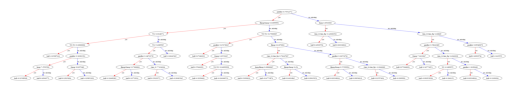

In [26]:
from xgboost import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model_enn, num_trees=0) 
plt.show()

### SMOTE-ENN Random forest

In [28]:
n_estimators = 100
model_rf_enn = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
model_rf_enn.fit(X_resampled_enn, y_resampled_enn)

# Obtener las probabilidades de la clase 1 (positiva)
y_pred_rf = model_rf_enn.predict(X_test)
# Evaluar el modelo usando el umbral ajustado
print("Resultados usando Random Forest con SMOTE-ENN y ajuste de umbral:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))

# Guardar el reporte en un archivo de texto
with open(f'graficos/RandomForest/SMOTE_ENN/reporte_rf_enn_{n_estimators}_estimators.txt', 'w') as f:
    f.write("Resultados usando Random Forest con SMOTE-ENN y ajuste de umbral:\n")
    f.write(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}\n")
    f.write("\nReporte de clasificacion:\n")
    f.write(classification_report(y_test, y_pred_rf))

dump(model_rf_enn, f'modelos/rf_enn_{n_estimators}.joblib')

# Calcular la matriz de confusión
cm_rf_enn = confusion_matrix(y_test, y_pred_rf)
print("Matriz de Confusión:")
print(cm_rf_enn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_enn, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Random Forest con SMOTE-ENN')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.savefig(f'graficos/RandomForest/SMOTE_ENN/matriz_confusion_rf_enn_{n_estimators}_estimators.png')
plt.close()

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Curva ROC (área = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Random Forest con SMOTE-ENN')
plt.legend(loc="lower right")
plt.savefig(f'graficos/RandomForest/SMOTE_ENN/roc_curve_rf_enn_{n_estimators}_estimators.png')
plt.close()

# Importancia de las características
importances_rf = model_rf_enn.feature_importances_
feature_importance_rf_df = pd.DataFrame({
    'Característica': X_resampled_enn.columns,  # Usa X_resampled_enn si X_train no está disponible
    'Importancia': importances_rf
})
feature_importance_rf_df = feature_importance_rf_df.sort_values(by='Importancia', ascending=False)

# Mostrar las primeras características más importantes
print("Características más importantes para la clasificación con Random Forest:")
print(feature_importance_rf_df.head(10))

# Graficar la importancia de las características
plt.figure(figsize=(10, 8))
sns.barplot(x='Importancia', y='Característica', data=feature_importance_rf_df.head(20))
plt.title('Importancia de las Características - Random Forest con SMOTE-ENN')
plt.tight_layout()
plt.savefig(f'graficos/RandomForest/SMOTE_ENN/feature_importances_rf_enn_{n_estimators}_estimators.png')
plt.close()

Resultados usando Random Forest con SMOTE-ENN y ajuste de umbral:
Accuracy: 0.9603174603174603
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       963
           1       0.54      0.82      0.65        45

    accuracy                           0.96      1008
   macro avg       0.76      0.89      0.81      1008
weighted avg       0.97      0.96      0.96      1008

Matriz de Confusión:
[[931  32]
 [  8  37]]
Características más importantes para la clasificación con Random Forest:
   Característica  Importancia
0        parallax     0.302647
15             W2     0.103968
7           W1-W2     0.102311
6       Hmag-Kmag     0.088467
13           Kmag     0.084765
14             W1     0.078204
12           Hmag     0.056439
5       Jmag-Kmag     0.034301
10        Gaia_Rp     0.022686
11           Jmag     0.022030


# SMOTE-TOMEK

In [29]:
smote_tomek = SMOTETomek(random_state=42)
X_resampled_tomek, y_resampled_tomek = smote_tomek.fit_resample(X_train, y_train)

print(X_resampled_enn.shape, y_resampled_enn.shape)
print(f"Antes de SMOTE_enn: {y_train.value_counts()}")
print(f"Después de SMOTE_enn: {y_resampled_enn.value_counts()}")

(7319, 16) (7319,)
Antes de SMOTE_enn: class
0    3850
1     180
Name: count, dtype: int64
Después de SMOTE_enn: class
1    3788
0    3531
Name: count, dtype: int64


In [30]:
n_estimators=100
model_tomek = XGBClassifier(eval_metric='mlogloss', learning_rate='0.1', objective='binary:logistic', n_estimators=n_estimators, random_state=42)
model_tomek.fit(X_resampled_tomek, y_resampled_tomek)

y_pred_tomek = model_tomek.predict(X_test)

print("Resultados usando SMOTE-Tomek:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tomek)}")
print(classification_report(y_test, y_pred_tomek))
dump(model_tomek, f'modelos/xg_tomek_{n_estimators}.joblib')


with open(f'graficos/XGBOOST/SMOTE_TOMEK/reporte_tomek_{n_estimators}_estimators.txt', 'w') as f:
    f.write("Resultados usando SMOTE-Tomek:\n")
    f.write(f"Accuracy: {accuracy_score(y_test, y_pred_tomek)}\n")
    f.write("\nReporte de clasificacion:\n")
    f.write(classification_report(y_test, y_pred_tomek))

Resultados usando SMOTE-Tomek:
Accuracy: 0.9732142857142857
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       963
           1       0.65      0.87      0.74        45

    accuracy                           0.97      1008
   macro avg       0.82      0.92      0.86      1008
weighted avg       0.98      0.97      0.98      1008



In [31]:
cm = confusion_matrix(y_test, y_pred_tomek)
print("Matriz de Confusión:")
print(cm)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - SMOTE-TOMEK')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.savefig(f'graficos/XGBOOST/SMOTE_TOMEK/matriz_confusion_tomek_{n_estimators}_estimators.png')
plt.close()

Matriz de Confusión:
[[942  21]
 [  6  39]]


In [32]:
y_pred_proba = model_tomek.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - SMOTE-TOMEK')
plt.legend(loc="lower right")
plt.savefig(f'graficos/XGBOOST/SMOTE_TOMEK/roc_curve_tomek_{n_estimators}_estimators.png')
plt.close()

In [33]:
importances = model_tomek.feature_importances_
feature_importance_df = pd.DataFrame({
    'Característica': X_train.columns,
    'Importancia': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)
print("Características más importantes para la clasificación:")
print(feature_importance_df.head(10))

plt.figure(figsize=(10,8))
plt.barh(feature_importance_df['Característica'], feature_importance_df['Importancia'])
plt.gca().invert_yaxis()  
plt.xlabel('Importancia')
plt.title('Importancia de las Características - SMOTE-TOMEK')
plt.tight_layout()
plt.savefig(f'graficos/XGBOOST/SMOTE_TOMEK/feature_importances_TOMEK_{n_estimators}_estimators.png')
plt.close()

Características más importantes para la clasificación:
    Característica  Importancia
6        Hmag-Kmag     0.260187
0         parallax     0.208915
15              W2     0.101810
13            Kmag     0.099462
11            Jmag     0.048855
7            W1-W2     0.042767
2   Gaia_G-Gaia_Rp     0.038812
10         Gaia_Rp     0.037635
1   Gaia_G-Gaia_Bp     0.033285
9          Gaia_Bp     0.031079


### RANDOM FOREST TOMEK

In [34]:
n_estimators = 100
model_rf_tomek = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
model_rf_tomek.fit(X_resampled_tomek, y_resampled_tomek)

y_pred_rf_tomek = model_rf_tomek.predict(X_test)

print("Resultados usando Random Forest con SMOTE-Tomek:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_tomek)}")
print(classification_report(y_test, y_pred_rf_tomek))
dump(model_rf_tomek, f'modelos/rf_tomek_{n_estimators}.joblib')

with open(f'graficos/RandomForest/SMOTE_TOMEK/reporte_rf_tomek_{n_estimators}_estimators.txt', 'w') as f:
    f.write("Resultados usando Random Forest con SMOTE-Tomek:\n")
    f.write(f"Accuracy: {accuracy_score(y_test, y_pred_rf_tomek)}\n")
    f.write("\nReporte de clasificacion:\n")
    f.write(classification_report(y_test, y_pred_rf_tomek))

cm_rf_tomek = confusion_matrix(y_test, y_pred_rf_tomek)
print("Matriz de Confusión:")
print(cm_rf_tomek)

plt.figure(figsize=(8,6))
sns.heatmap(cm_rf_tomek, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Random Forest con SMOTE-Tomek')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.savefig(f'graficos/RandomForest/SMOTE_TOMEK/matriz_confusion_rf_tomek_{n_estimators}_estimators.png')
plt.close()



y_pred_proba_rf = model_rf_tomek.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'Curva ROC (área = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Random Forest con SMOTE-Tomek')
plt.legend(loc="lower right")
plt.savefig(f'graficos/RandomForest/SMOTE_TOMEK/roc_curve_rf_tomek_{n_estimators}_estimators.png')
plt.close()

importances_rf = model_rf_tomek.feature_importances_
feature_importance_rf_df = pd.DataFrame({
    'Característica': X_train.columns,
    'Importancia': importances_rf
})
feature_importance_rf_df = feature_importance_rf_df.sort_values(by='Importancia', ascending=False)

print("Características más importantes para la clasificación con Random Forest:")
print(feature_importance_rf_df.head(10))

plt.figure(figsize=(10,8))
sns.barplot(x='Importancia', y='Característica', data=feature_importance_rf_df.head(20))
plt.title('Importancia de las Características - Random Forest con SMOTE-Tomek')
plt.tight_layout()
plt.savefig(f'graficos/RandomForest/SMOTE_TOMEK/feature_importances_rf_tomek_{n_estimators}_estimators.png')
plt.close()


Resultados usando Random Forest con SMOTE-Tomek:
Accuracy: 0.9732142857142857
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       963
           1       0.66      0.82      0.73        45

    accuracy                           0.97      1008
   macro avg       0.83      0.90      0.86      1008
weighted avg       0.98      0.97      0.97      1008

Matriz de Confusión:
[[944  19]
 [  8  37]]
Características más importantes para la clasificación con Random Forest:
   Característica  Importancia
0        parallax     0.300381
7           W1-W2     0.097941
6       Hmag-Kmag     0.090996
14             W1     0.084066
15             W2     0.082370
13           Kmag     0.080133
12           Hmag     0.055220
5       Jmag-Kmag     0.037579
11           Jmag     0.025941
4       Jmag-Hmag     0.024545


# SMOTE normal

In [35]:
smote = SMOTE(random_state=42)
X_resampled_smt, y_resampled_smt = smote.fit_resample(X_train, y_train)

print(X_resampled_smt.shape, y_resampled_smt.shape)
print(f"Antes de SMOTE: {y_train.value_counts()}")
print(f"Después de SMOTE: {y_resampled_smt.value_counts()}")

(7700, 16) (7700,)
Antes de SMOTE: class
0    3850
1     180
Name: count, dtype: int64
Después de SMOTE: class
0    3850
1    3850
Name: count, dtype: int64


In [36]:
n_estimators = 100
model_smt = XGBClassifier(eval_metric='mlogloss', learning_rate='0.1', objective='binary:logistic', n_estimators=n_estimators, random_state=42)
model_smt.fit(X_resampled_smt, y_resampled_smt)

y_pred_smt = model_smt.predict(X_test)

print("Resultados usando SMOTE:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_smt)}")
print(classification_report(y_test, y_pred_smt))
dump(model_smt, f'modelos/xg_smt_{n_estimators}.joblib')

with open(f'graficos/XGBOOST/SMOTE/reporte_{n_estimators}_estimators.txt', 'w') as f:
    f.write("Resultados usando SMOTE:\n")
    f.write(f"Accuracy: {accuracy_score(y_test, y_pred_smt)}\n")
    f.write("\nReporte de clasificacion:\n")
    f.write(classification_report(y_test, y_pred_smt))

Resultados usando SMOTE:
Accuracy: 0.9751984126984127
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       963
           1       0.67      0.87      0.76        45

    accuracy                           0.98      1008
   macro avg       0.83      0.92      0.87      1008
weighted avg       0.98      0.98      0.98      1008



In [37]:
cm = confusion_matrix(y_test, y_pred_smt)
print("Matriz de Confusión:")
print(cm)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - SMOTE')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.savefig(f'graficos/XGBOOST/SMOTE/matriz_confusion_smt_{n_estimators}_estimators.png')
plt.close()

Matriz de Confusión:
[[944  19]
 [  6  39]]


In [38]:
y_pred_proba = model_smt.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - SMOTE-TOMEK')
plt.legend(loc="lower right")
plt.savefig(f'graficos/XGBOOST/SMOTE/roc_curve_smt_{n_estimators}_estimators.png')
plt.close()

In [39]:
importances = model_tomek.feature_importances_
feature_importance_df = pd.DataFrame({
    'Característica': X_train.columns,
    'Importancia': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)
print("Características más importantes para la clasificación:")
print(feature_importance_df.head(10))

plt.figure(figsize=(10,8))
plt.barh(feature_importance_df['Característica'], feature_importance_df['Importancia'])
plt.gca().invert_yaxis()  
plt.xlabel('Importancia')
plt.title('Importancia de las Características - SMOTE-ENN')
plt.tight_layout()
plt.savefig(f'graficos/XGBOOST/SMOTE_TOMEK/feature_importances_enn_{n_estimators}_estimators.png')
plt.close()

Características más importantes para la clasificación:
    Característica  Importancia
6        Hmag-Kmag     0.260187
0         parallax     0.208915
15              W2     0.101810
13            Kmag     0.099462
11            Jmag     0.048855
7            W1-W2     0.042767
2   Gaia_G-Gaia_Rp     0.038812
10         Gaia_Rp     0.037635
1   Gaia_G-Gaia_Bp     0.033285
9          Gaia_Bp     0.031079


In [40]:
importances = model_smt.feature_importances_
feature_importance_df = pd.DataFrame({
    'Característica': X_train.columns,
    'Importancia': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)
print("Características más importantes para la clasificación:")
print(feature_importance_df.head(10))

plt.figure(figsize=(10,8))
plt.barh(feature_importance_df['Característica'], feature_importance_df['Importancia'])
plt.gca().invert_yaxis()  
plt.xlabel('Importancia')
plt.title('Importancia de las Características - SMOTE')
plt.tight_layout()
plt.savefig(f'graficos/XGBOOST/SMOTE/feature_importances_smt_{n_estimators}_estimators.png')
plt.close()

Características más importantes para la clasificación:
    Característica  Importancia
6        Hmag-Kmag     0.253468
0         parallax     0.215193
13            Kmag     0.102946
15              W2     0.098487
7            W1-W2     0.048370
10         Gaia_Rp     0.045921
11            Jmag     0.045206
2   Gaia_G-Gaia_Rp     0.042539
1   Gaia_G-Gaia_Bp     0.032662
9          Gaia_Bp     0.024482


### RANDOM FOREST SMOTE

In [41]:
n_estimators = 100
model_rf_smt = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
model_rf_smt.fit(X_resampled_smt, y_resampled_smt)

y_pred_rf_smt = model_rf_smt.predict(X_test)

# Evaluar el modelo
print("Resultados usando Random Forest con SMOTE:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_smt)}")
print(classification_report(y_test, y_pred_rf_smt))
dump(model_rf_smt, f'modelos/rf_smt_{n_estimators}.joblib')

# Guardar el reporte en un archivo de texto
with open(f'graficos/RandomForest/SMOTE/reporte_rf_smt_{n_estimators}_estimators.txt', 'w') as f:
    f.write("Resultados usando Random Forest con SMOTE:\n")
    f.write(f"Accuracy: {accuracy_score(y_test, y_pred_rf_smt)}\n")
    f.write("\nReporte de clasificacion:\n")
    f.write(classification_report(y_test, y_pred_rf_smt))

# Matriz de confusión
cm_rf_smt = confusion_matrix(y_test, y_pred_rf_smt)
print("Matriz de Confusión:")
print(cm_rf_smt)

plt.figure(figsize=(8,6))
sns.heatmap(cm_rf_smt, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Random Forest con SMOTE')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.savefig(f'graficos/RandomForest/SMOTE/matriz_confusion_rf_smt_{n_estimators}_estimators.png')
plt.close()


# ROC

y_pred_proba_rf = model_rf_smt.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'Curva ROC (área = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Random Forest con SMOTE')
plt.legend(loc="lower right")
plt.savefig(f'graficos/RandomForest/SMOTE/roc_curve_rf_smt_{n_estimators}_estimators.png')
plt.close()

# Importancias
importances_rf = model_rf_smt.feature_importances_
feature_importance_rf_df = pd.DataFrame({
    'Característica': X_train.columns,
    'Importancia': importances_rf
})
feature_importance_rf_df = feature_importance_rf_df.sort_values(by='Importancia', ascending=False)

print("Características más importantes para la clasificación con Random Forest:")
print(feature_importance_rf_df.head(10))

plt.figure(figsize=(10,8))
sns.barplot(x='Importancia', y='Característica', data=feature_importance_rf_df.head(20))
plt.title('Importancia de las Características - Random Forest con SMOTE')
plt.tight_layout()
plt.savefig(f'graficos/RandomForest/SMOTE/feature_importances_rf_smt_{n_estimators}_estimators.png')
plt.close()

Resultados usando Random Forest con SMOTE:
Accuracy: 0.9732142857142857
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       963
           1       0.65      0.87      0.74        45

    accuracy                           0.97      1008
   macro avg       0.82      0.92      0.86      1008
weighted avg       0.98      0.97      0.98      1008

Matriz de Confusión:
[[942  21]
 [  6  39]]
Características más importantes para la clasificación con Random Forest:
    Característica  Importancia
0         parallax     0.314929
7            W1-W2     0.103271
15              W2     0.087229
6        Hmag-Kmag     0.085602
14              W1     0.079400
13            Kmag     0.077541
12            Hmag     0.048616
5        Jmag-Kmag     0.034645
2   Gaia_G-Gaia_Rp     0.024746
10         Gaia_Rp     0.023492


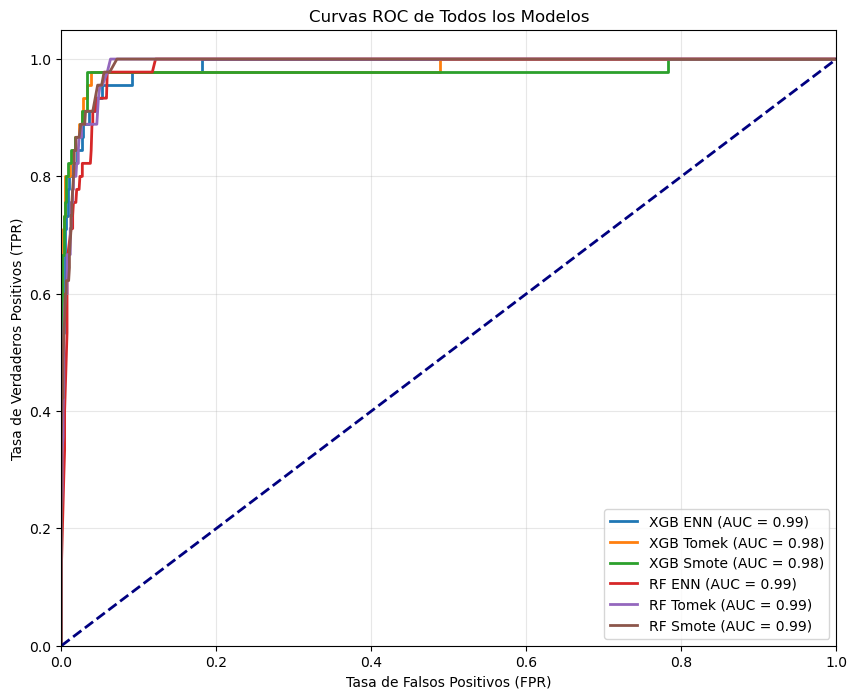

In [42]:
modelos = [model_enn, model_tomek, model_smt, model_rf_enn, model_rf_tomek, model_rf_smt]  
nombres_modelos = ['XGB ENN', 'XGB Tomek', 'XGB Smote', 'RF ENN', 'RF Tomek', 'RF Smote']
y_true = y_test 

plt.figure(figsize=(10, 8))
for i, modelo in enumerate(modelos):
    y_pred_prob = modelo.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{nombres_modelos[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC de Todos los Modelos')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig('graficos/ROC.png')
plt.show()

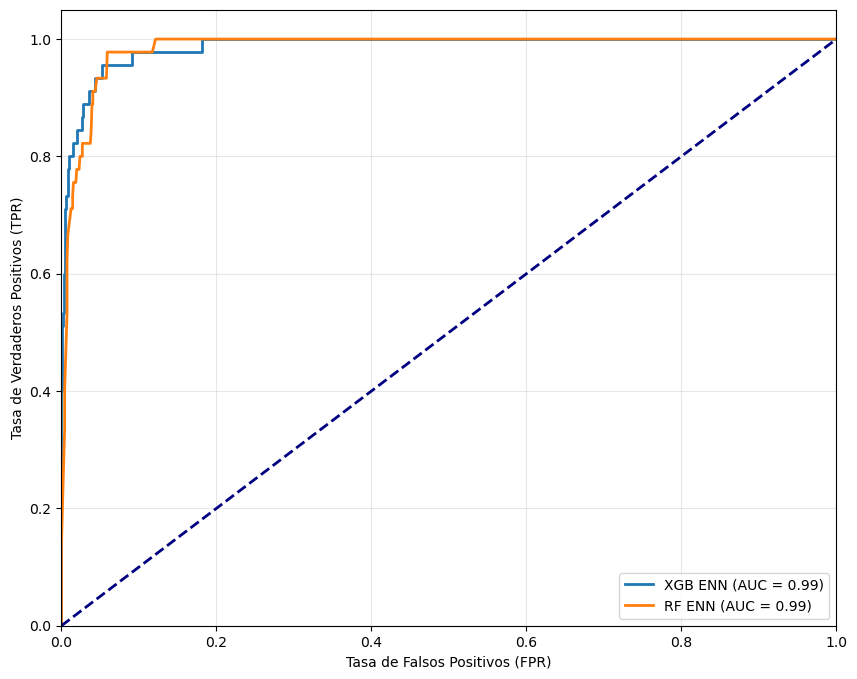

In [43]:
modelos = [model_enn, model_rf_enn]  
nombres_modelos = ['XGB ENN', 'RF ENN']
y_true = y_test 

plt.figure(figsize=(10, 8))
for i, modelo in enumerate(modelos):
    y_pred_prob = modelo.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{nombres_modelos[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig('graficos/ROC_2.png')
plt.show()

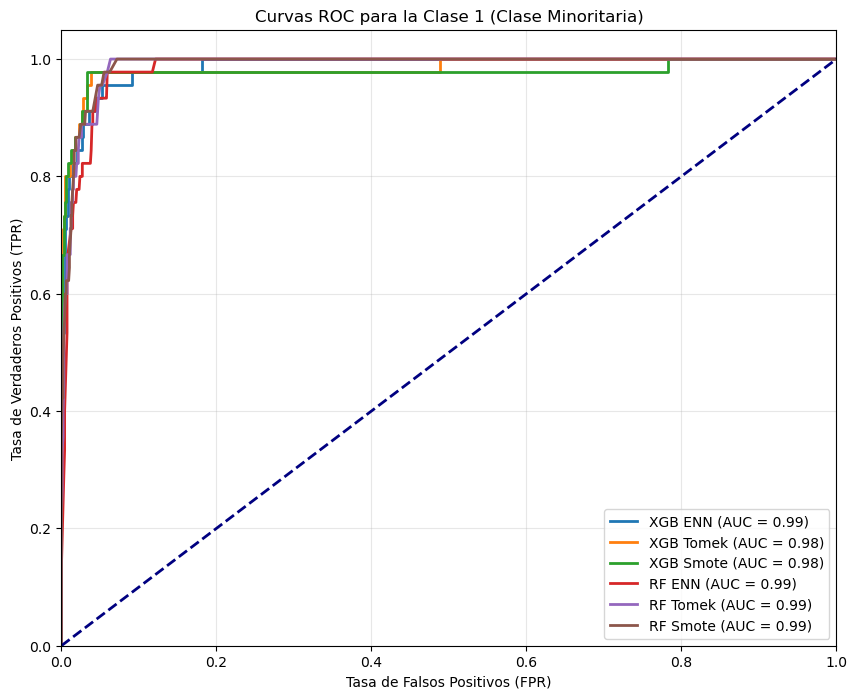

In [44]:
modelos = [model_enn, model_tomek, model_smt, model_rf_enn, model_rf_tomek, model_rf_smt]
nombres_modelos = ['XGB ENN', 'XGB Tomek', 'XGB Smote', 'RF ENN', 'RF Tomek', 'RF Smote']
y_true = y_test
plt.figure(figsize=(10, 8))

# Iterar sobre los modelos para generar curvas ROC
for i, modelo in enumerate(modelos):
    # Predecir probabilidades para la clase 1
    y_pred_prob = modelo.predict_proba(X_test)[:, 1]
    
    # Calcular FPR (False Positive Rate) y TPR (True Positive Rate) para la clase 1
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob, pos_label=1)
    
    # Calcular el área bajo la curva (AUC)
    roc_auc = auc(fpr, tpr)
    
    # Dibujar la curva ROC
    plt.plot(fpr, tpr, lw=2, label=f'{nombres_modelos[i]} (AUC = {roc_auc:.2f})')

# Agregar la línea diagonal de referencia
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Configurar los ejes y el título
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC para la Clase 1 (Clase Minoritaria)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.savefig('graficos/ROC_clase_1.png')
plt.show()

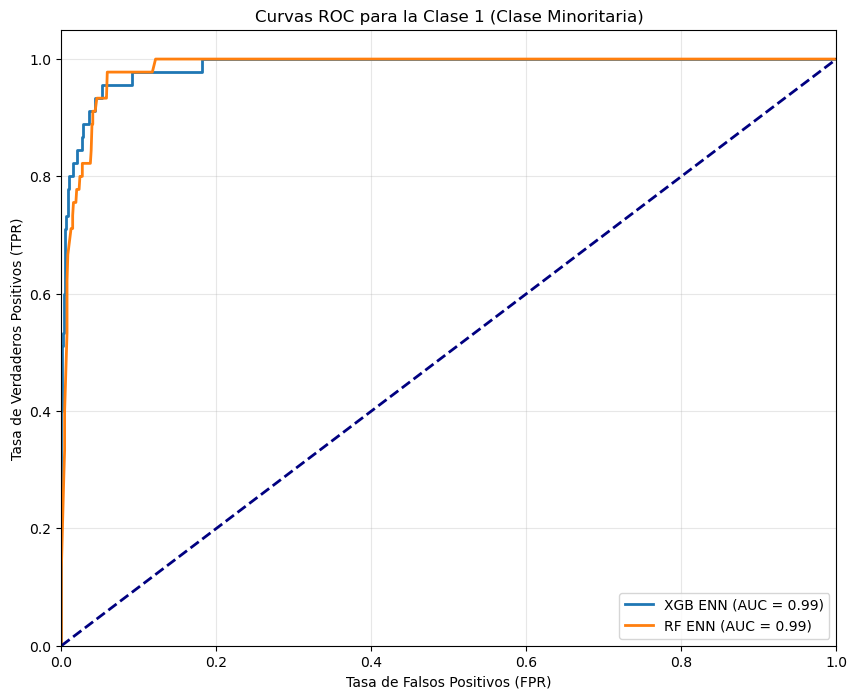

In [45]:
modelos = [model_enn, model_rf_enn]
nombres_modelos = ['XGB ENN', 'RF ENN']
y_true = y_test
plt.figure(figsize=(10, 8))

# Iterar sobre los modelos para generar curvas ROC
for i, modelo in enumerate(modelos):
    # Predecir probabilidades para la clase 1
    y_pred_prob = modelo.predict_proba(X_test)[:, 1]
    
    # Calcular FPR (False Positive Rate) y TPR (True Positive Rate) para la clase 1
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob, pos_label=1)
    
    # Calcular el área bajo la curva (AUC)
    roc_auc = auc(fpr, tpr)
    
    # Dibujar la curva ROC
    plt.plot(fpr, tpr, lw=2, label=f'{nombres_modelos[i]} (AUC = {roc_auc:.2f})')

# Agregar la línea diagonal de referencia
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Configurar los ejes y el título
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC para la Clase 1 (Clase Minoritaria)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.savefig('graficos/ROC_clase_1.png')
plt.show()

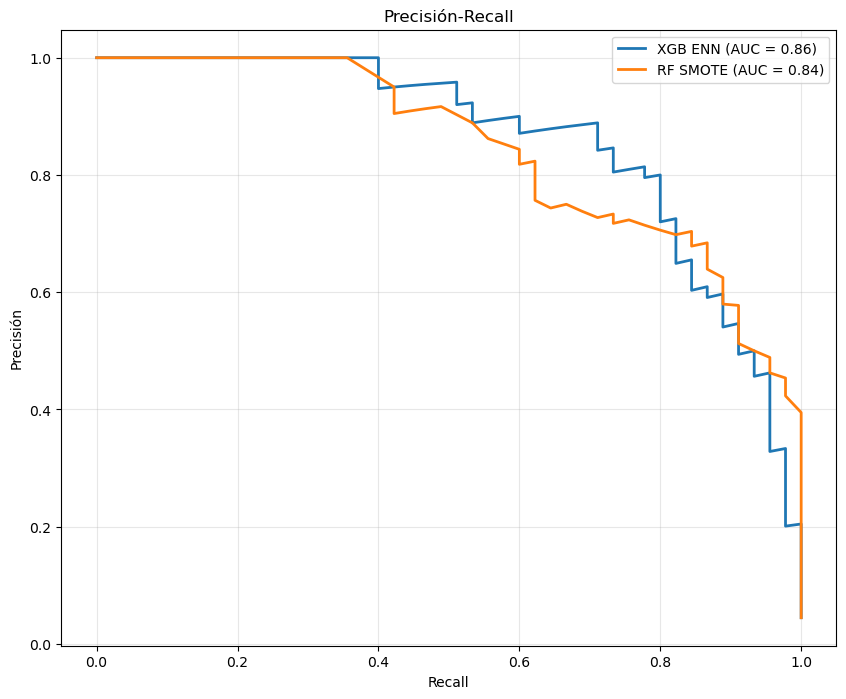

In [46]:
from sklearn.metrics import precision_recall_curve, average_precision_score
plt.figure(figsize=(10, 8))
modelos = [model_enn, model_rf_smt]
nombres_modelos = ['XGB ENN', 'RF SMOTE']
for i, modelo in enumerate(modelos):
    y_pred_prob = modelo.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    avg_precision = average_precision_score(y_true, y_pred_prob)
    plt.plot(recall, precision, lw=2, label=f'{nombres_modelos[i]} (AUC = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Precisión-Recall')
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.savefig('graficos/Precision_Recall.png')
plt.show()

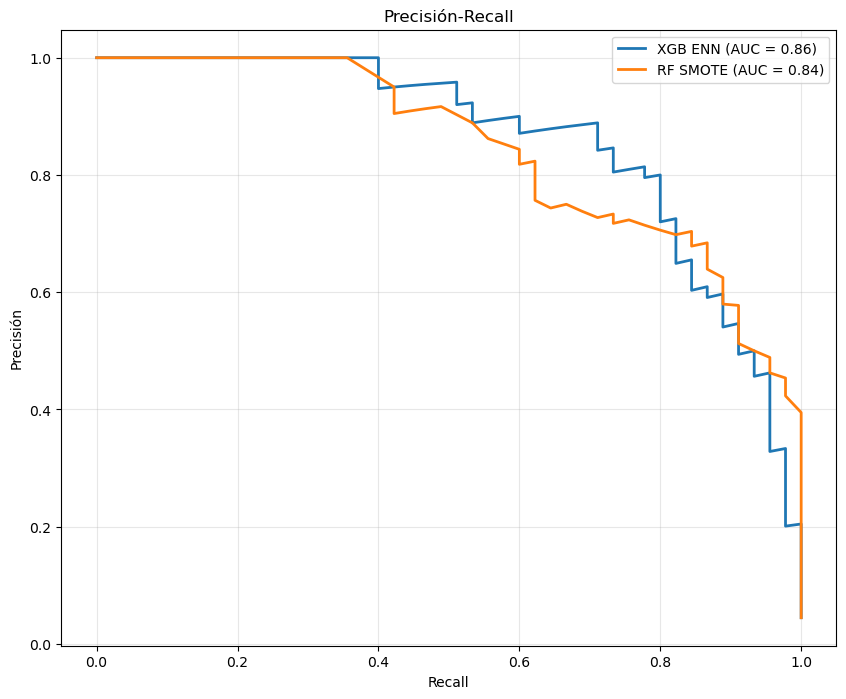

In [47]:
from sklearn.metrics import precision_recall_curve, average_precision_score
plt.figure(figsize=(10, 8))
for i, modelo in enumerate(modelos):
    y_pred_prob = modelo.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    avg_precision = average_precision_score(y_true, y_pred_prob)
    plt.plot(recall, precision, lw=2, label=f'{nombres_modelos[i]} (AUC = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Precisión-Recall')
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.savefig('graficos/Precision_Recall.png')
plt.show()

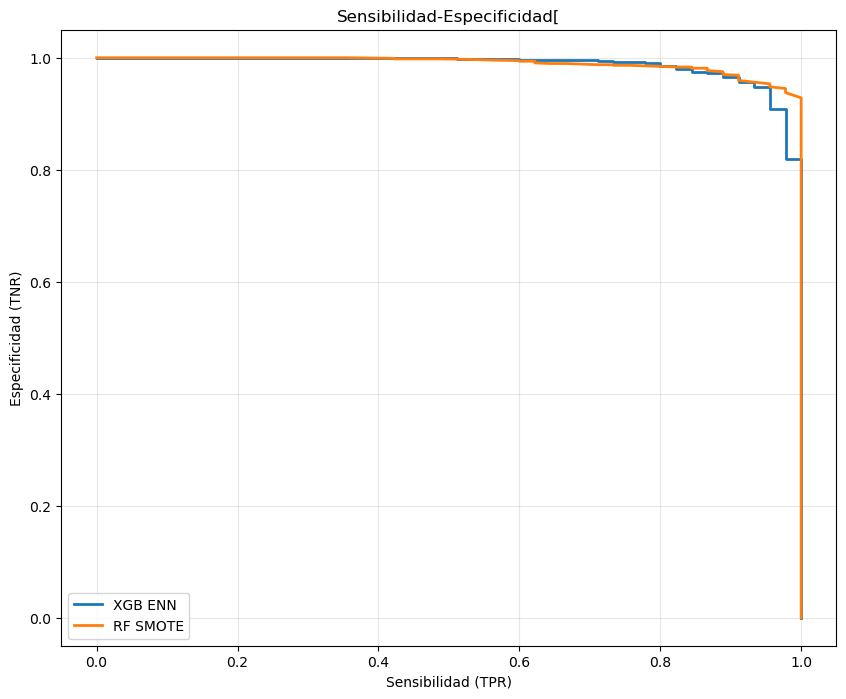

In [48]:
plt.figure(figsize=(10, 8))
for i, modelo in enumerate(modelos):
    y_pred_prob = modelo.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    tnr = 1 - fpr  # La especificidad es el complemento de FPR
    plt.plot(tpr, tnr, lw=2, label=f'{nombres_modelos[i]}')

plt.xlabel('Sensibilidad (TPR)')
plt.ylabel('Especificidad (TNR)')
plt.title('Sensibilidad-Especificidad[')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.savefig('graficos/Sensibilidad_Especificidad.png')
plt.show()

In [49]:
X_val = wolf_rayet_sample[['parallax', 'Gaia_G-Gaia_Bp', 'Gaia_G-Gaia_Rp', 'Gaia_Bp-Gaia_Rp', 
                           'Jmag-Hmag', 'Jmag-Kmag', 'Hmag-Kmag', 'W1-W2', 
                           'Gaia_G', 'Gaia_Bp', 'Gaia_Rp', 'Jmag', 'Hmag', 'Kmag', 'W1', 
                           'W2']]
modelos = [model_enn, model_tomek, model_smt, model_rf_enn, model_rf_tomek, model_rf_smt]
nombres_modelos = ['XGB ENN', 'XGB Tomek', 'XGB Smote', 'RF ENN', 'RF Tomek', 'RF Smote']
umbral_personalizado = 0.95

predicciones_umbral_df = pd.DataFrame(index=wolf_rayet_sample.index)

for modelo, nombre in zip(modelos, nombres_modelos):
    y_pred_proba = modelo.predict_proba(X_val)[:, 1]
    
    y_pred_custom = (y_pred_proba >= umbral_personalizado).astype(int)
    predicciones_umbral_df[nombre] = y_pred_custom

print(f"Predicciones de las 15 estrellas eliminadas con umbral personalizado ({umbral_personalizado}):")
print(predicciones_umbral_df)

predicciones_umbral_df['Clase Verdadera'] = 1
correctas_umbral = predicciones_umbral_df.drop(columns='Clase Verdadera').eq(predicciones_umbral_df['Clase Verdadera'], axis=0).sum()

print(f"\nCantidad de estrellas correctamente identificadas ({umbral_personalizado}):")
print(correctas_umbral)

Predicciones de las 15 estrellas eliminadas con umbral personalizado (0.95):
    XGB ENN  XGB Tomek  XGB Smote  RF ENN  RF Tomek  RF Smote
0         1          0          0       0         0         0
1         1          1          1       1         0         1
2         0          0          0       0         0         0
3         0          0          0       0         0         0
4         1          0          0       0         0         0
5         0          0          0       0         0         0
6         1          1          1       1         1         1
7         1          1          1       0         0         0
8         1          1          1       0         0         0
9         1          1          1       1         1         1
10        1          1          1       1         1         1
11        1          1          1       1         1         0
12        1          0          0       0         0         0
13        1          1          1       1         1    

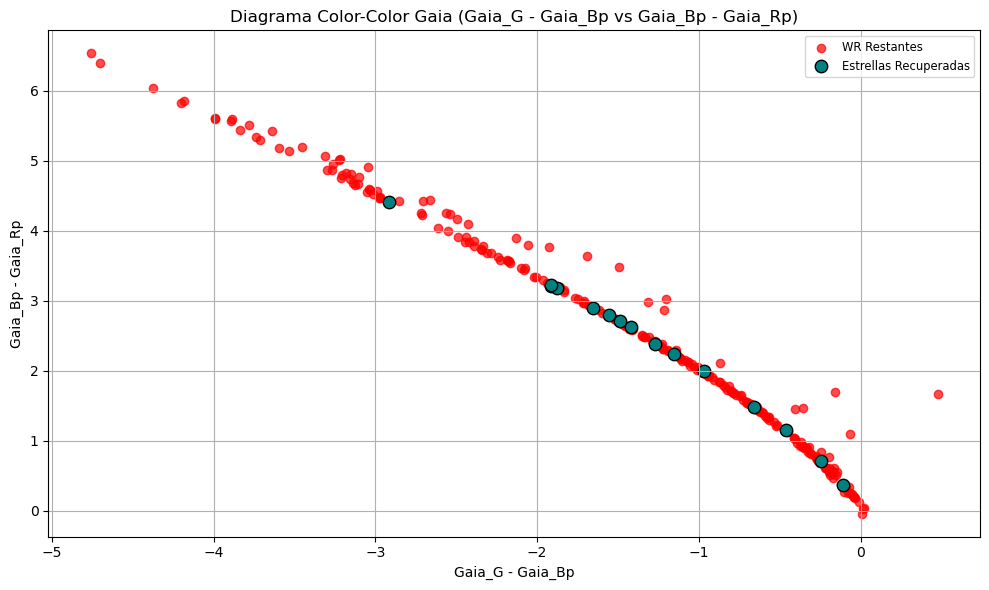

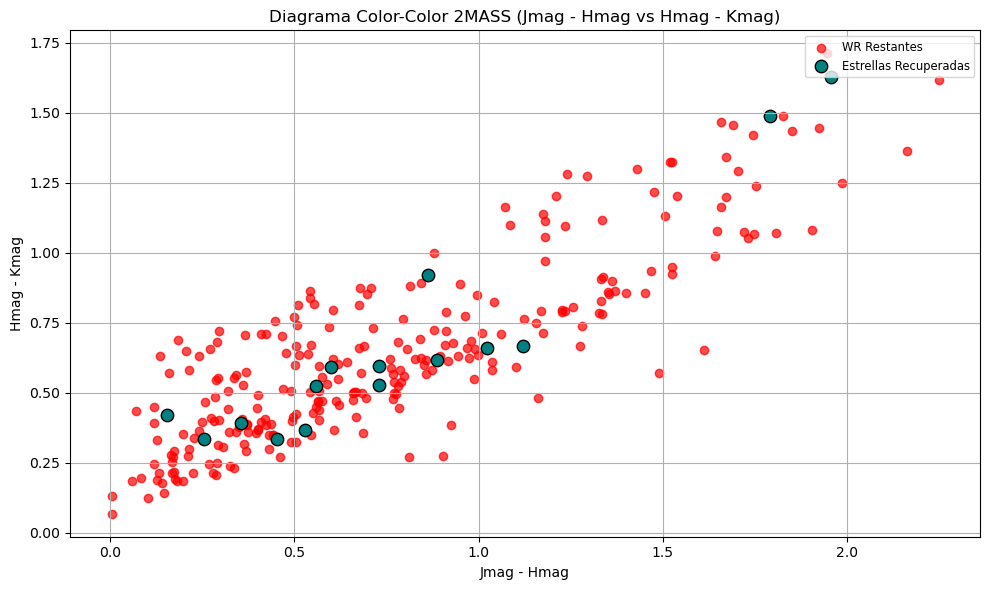

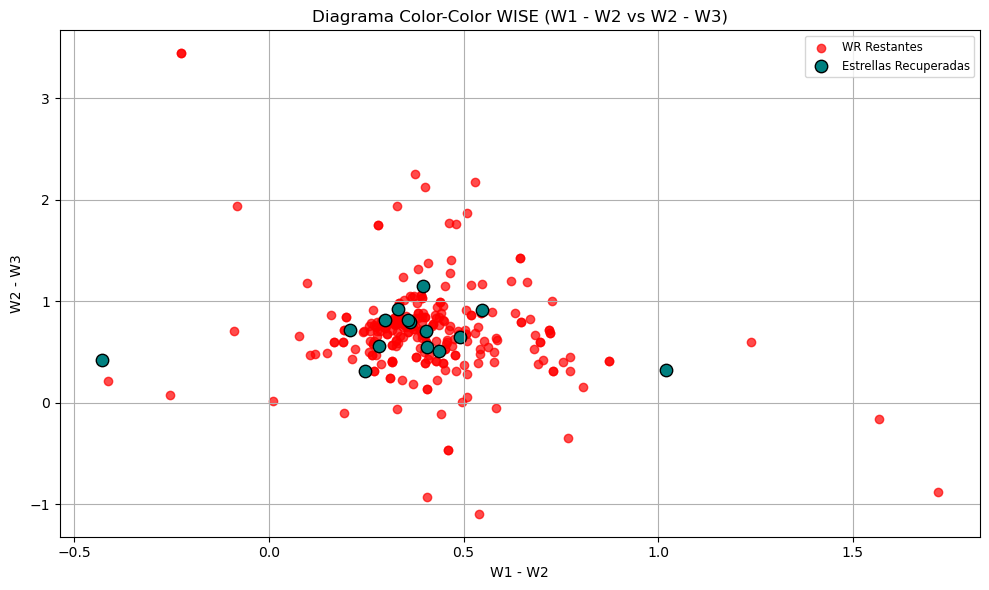

In [50]:
import seaborn as sns

indices_estrellas_recuperadas = predicciones_umbral_df .index  # Los índices corresponden a las 15 estrellas eliminadas

plt.figure(figsize=(10, 6))
plt.scatter(wolf_rayet['Gaia_G-Gaia_Bp'], wolf_rayet['Gaia_Bp-Gaia_Rp'], color='red', alpha=0.7, label='WR Restantes')
plt.scatter(wolf_rayet_sample['Gaia_G-Gaia_Bp'], wolf_rayet_sample['Gaia_Bp-Gaia_Rp'],
            color='teal', label='Estrellas Recuperadas', s=80, edgecolors='black')
plt.xlabel('Gaia_G - Gaia_Bp')
plt.ylabel('Gaia_Bp - Gaia_Rp')
plt.title('Diagrama Color-Color Gaia (Gaia_G - Gaia_Bp vs Gaia_Bp - Gaia_Rp)')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# Colores de 2MASS (J, H, K)
plt.figure(figsize=(10, 6))
plt.scatter(wolf_rayet['Jmag-Hmag'], wolf_rayet['Hmag-Kmag'], color='red', alpha=0.7, label='WR Restantes')
plt.scatter(wolf_rayet_sample['Jmag-Hmag'], wolf_rayet_sample['Hmag-Kmag'],
            color='teal', label='Estrellas Recuperadas', s=80, edgecolors='black')
plt.xlabel('Jmag - Hmag')
plt.ylabel('Hmag - Kmag')
plt.title('Diagrama Color-Color 2MASS (Jmag - Hmag vs Hmag - Kmag)')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# Colores de WISE (W1, W2, W3)
plt.figure(figsize=(10, 6))
plt.scatter(wolf_rayet['W1-W2'], wolf_rayet['W2-W3'], color='red', alpha=0.7, label='WR Restantes')
plt.scatter(wolf_rayet_sample['W1-W2'], wolf_rayet_sample['W2-W3'],
            color='teal', label='Estrellas Recuperadas', s=80, edgecolors='black')
plt.xlabel('W1 - W2')
plt.ylabel('W2 - W3')
plt.title('Diagrama Color-Color WISE (W1 - W2 vs W2 - W3)')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()